# Predicting Track Popularity Using Audio Features
## An exploration of the Spotify dataset
This tutorial will give an introduction to the data science pipeline by exploring musical data provided by Spotify. We will first see how to use an API to collect data, then create visualizations using that data to better understand it, and finally, attempt to use metadata of a song to predict the popularity of that song with the use of machine learning.

Spotify is very generous with the amount of data they provide through their API, some of which is not obvious that they would even collect, let alone make publically available. Some of those features in particular are 

* Acousticness
* Danceability
* Energy
* Instrumentalness
* Liveness
* Speechiness
* and Valence

And, of course, popularity, each of which are scores from 0 to 100. When I found out this information existed, my immediate thought was "How could they possibly give every song a danceability score?" With no answer to that, I then wondered to myself: is there any way these scores are related to the popularity of a song? With that question in mind, I turned to python to see what I could find. Feel free to follow along on my journey!


This project will be using the Spotify api and its python connector, Spotipy. More can be read about those here:

* Spotify Web API: https://developer.spotify.com/web-api/console/
* Spotipy Documentation: http://spotipy.readthedocs.io/en/latest/

The descriptions of the particular variables can be found at the following link, in addition to descriptions to all other objects that one might come across when dealing with this dataset.

* https://developer.spotify.com/web-api/object-model/#audio-features-object

## Installing libraries
Spotipy is the only uncommon library needed, however other common libraries like Pandas and SciKit-Learn will also be used. Spotipy can be downloaded easily using pip

```bash
pip install spotipy
```

Ensure that the following code can be excuted before following on.

In [1]:
# Data collection
import spotipy
from spotipy import util
import requests
from bs4 import BeautifulSoup
import io

# Data manipulation
import pandas as pd
import numpy as np

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt

# Prediction
from sklearn import model_selection
from sklearn import linear_model

import random
import datetime

## Data Collection

In order to follow along with this portion of the tutorial, you will need to have access to the Spotify API. This requires that you register your application with Spotify, a process described here:

* https://developer.spotify.com/my-applications/#!/applications

If you would rather not do this but still want to explore the data, I have made the data I have collected available on my github page. Skip to the end of this section to learn more. If you are able to register an application, you should be able to use the Spotipy package to connect to Spotify with the following commands:

In [2]:
token = util.prompt_for_user_token("user_name", 'permissions',
                        client_id='client_id',
                        client_secret='slient_secret',
                        redirect_uri='https://www.google.com')

if not token:
    raise SystemError("Cannot connect to Spotify")
    
sp = spotipy.Spotify(auth=token)

Replace the placeholders with your information. The variable ```sp``` will serve as the connection to Spotify's databases and will be necessary throughout the data collection phase.

Before we get into the data collection, I have written a small helper function that will come in handy later. To avoid unnecessary work, Spotify returns its results in a type of linked list that only has the information of the current node and the instructions on how to get the information of the next node. This is good for some applications, but we want all the results any way, so this function transforms the Spotify linked list into python list. It will be much easier to work with the data in this format.

In [3]:
def results2list(sp, results):
    lst = []
    if results:
        lst.extend(results['items'])
        while results['next']:
            results = sp.next(results)
            lst.extend(results['items'])
    return lst

Unfortunately for us, Spotify does not provide any master dataset with information about all of their tracks, they only allow queries for specific information. To get around this, we will write several functions doing just that: asking for a specific artist, the albums a specic artist has made, and the tracks on a specific album.

The first function here returns artist information when given a name or an ID of an artist.

In [4]:
def get_artist(sp, artist, identifier="id"):
    # if the ID is known, query for that exact artist
    if identifier == 'id':
        return sp.artist(artist)
    
    # if only the name is known, search for an artist with that name 
    # and return first search result 
    elif identifier == 'name': 
        results = sp.search(q='artist:' + artist, type='artist')
        items = results['artists']['items']
        if len(items) > 0:
            artist = items[0]
            return artist
        
    return None

To see if we can successfully access Spotify's databases, we will test this function by looking for the information of one of my favorite musicians currently, J. Cole.

In [5]:
artist = get_artist(sp, "J. Cole", identifier='name')
artist

{'external_urls': {'spotify': 'https://open.spotify.com/artist/6l3HvQ5sa6mXTsMTB19rO5'},
 'followers': {'href': None, 'total': 2827753},
 'genres': ['pop rap', 'rap'],
 'href': 'https://api.spotify.com/v1/artists/6l3HvQ5sa6mXTsMTB19rO5',
 'id': '6l3HvQ5sa6mXTsMTB19rO5',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/58f2a5fad6993299dc8bb93d10f8f15a2a85eb82',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/c16b1dea590b94729285b948c5d7fd7c2540eb83',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/26fc8306ea4cb17ec6fdc0a21aa044803b0be26a',
   'width': 160}],
 'name': 'J. Cole',
 'popularity': 86,
 'type': 'artist',
 'uri': 'spotify:artist:6l3HvQ5sa6mXTsMTB19rO5'}

This looks like it is return the right information, however there is a lot of information here that isn't relevant to us. We do not want this information taking up valuable memory, so here is a ```prep_artist()``` function to transform the artist object into something more reasonable.

In [6]:
def prep_artist(artist):
    # Remove unnecessary information
    remove_keys = ['external_urls', 'href', 'images', 'type', 'uri']
    for key in remove_keys:
        artist.pop(key, None)
    
    # ID changed so it can be used in mongo
    artist['_id'] = artist.pop('id', None)
    
    # Remove extra information
    artist['followers'] = artist['followers']['total']

    artist['expanded'] = False
    artist['retrieved_albums'] = False

    return artist

artist = prep_artist(artist)
artist

{'_id': '6l3HvQ5sa6mXTsMTB19rO5',
 'expanded': False,
 'followers': 2827753,
 'genres': ['pop rap', 'rap'],
 'name': 'J. Cole',
 'popularity': 86,
 'retrieved_albums': False}

This looks much better! I also added two additional fields to the object ```expanded``` and ```retrieved_ablums```. The ```expanded``` will be addressed toward the end of this section and the ```retrieved_ablums``` says whether or not we have collected information about this artists albums. That step comes next.

Getting the album information is as simple as querying the database for an artists albums. I have also preemptively added a similar function to the previous ```prep_artist()``` function, ```prep_album()```.

In [7]:
def get_artist_albums(sp, artist_id):
    albums = results2list(sp, sp.artist_albums(artist_id))
    # Get full album object
    albums = [ sp.album(album['id']) for album in albums ]
    return albums

def prep_album(album):
    # Remove unnecessary information
    remove_keys = ['available_markets', 'copyrights', 'external_ids', 'external_urls',
                   'href', 'images', 'label', 'tracks', 'type', 'uri']
    for key in remove_keys:
        album.pop(key, None)

    # ID changed so it can be used in mongo
    album['_id'] = album.pop('id', None)
    
    # Remove extra information
    album['artists'] = [ artist['id'] for artist in album['artists'] ]

    album['retrieved_tracks'] = False

    return album

album = get_artist_albums(sp, artist['_id'])[0]
album = prep_album(album)
album

{'_id': '71DEqZQPK1OhGtZ9bNtbcc',
 'album_type': 'album',
 'artists': ['6l3HvQ5sa6mXTsMTB19rO5'],
 'genres': [],
 'name': '4 Your Eyez Only',
 'popularity': 73,
 'release_date': '2016-12-09',
 'release_date_precision': 'day',
 'retrieved_tracks': False}

And lastly, the track information. This is very similar to retrieving albums except the track information we want is stored in two different places so two queries must be made.

In [8]:
def get_album_tracks(sp, album_id):
    tracks = results2list(sp, sp.album_tracks(album_id))
    # Get full track object
    tracks = [ sp.track(track['id']) for track in tracks ]
    tracks = [ track for track in tracks if track != None ]
    # Get the audio features of all tracks
    try:
        audios = sp.audio_features([ track['id'] for track in tracks if track ])
    except spotipy.client.SpotifyException as se:
        if se.http_status == 414:
            # Occurs when url is too long. The url is the list of track ids, so this means
            # too many tracks are in the list. Too fix this, look up audio features one at a time.
            # This is slower, but it works.
            audios = [ sp.audio_features(track['id'])[0] for track in tracks if track ]
            return [ {**track, **audio} for track, audio in zip(tracks, audios) if track and audio]
        elif se.http_status == 400:
            return []
    # Match the track with its audio features and get the CSV if they both exist
    return [ {**track, **audio} for track, audio in zip(tracks, audios) if track and audio]

def prep_track(track):
    # Remove unnecessary information
    remove_keys = ['analysis_url', 'available_markets', 'external_ids', 'external_urls', 'href', 
                   'linked_from', 'preview_url', 'track_href', 'type', 'uri']
    for key in remove_keys:
        track.pop(key, None)

    # ID changed so it can be used in mongo
    track['_id'] = track.pop('id', None)
    
    # Remove extra information
    track['album'] = track['album']['id']
    track['artists'] = [ artist['id'] for artist in track['artists'] ]

    return track

track = get_album_tracks(sp, album['_id'])[0]
track = prep_track(track)
track

{'_id': '6Czb2BTCg2CMjbKFYNGTap',
 'acousticness': 0.475,
 'album': '71DEqZQPK1OhGtZ9bNtbcc',
 'artists': ['6l3HvQ5sa6mXTsMTB19rO5'],
 'danceability': 0.391,
 'disc_number': 1,
 'duration_ms': 127880,
 'energy': 0.403,
 'explicit': True,
 'instrumentalness': 0,
 'key': 10,
 'liveness': 0.294,
 'loudness': -11.002,
 'mode': 0,
 'name': 'For Whom The Bell Tolls',
 'popularity': 61,
 'speechiness': 0.0805,
 'tempo': 74.657,
 'time_signature': 4,
 'track_number': 1,
 'valence': 0.184}

And there is the information we want!

Now that we have a way of getting the information we need about artists, their albums, and the tracks on those albums, we are almost ready to start downloading information from Spotify in bulk. First, one last problem needs to be solved: we need some master list of artists to get the information of. Spotify does not make this easy, so instead we will look to Billboard, who conveniently has a list of the current top 100 artists - a great starting point!

In [9]:
def get_artists_from_billboard():
    artists_url = "https://www.billboard.com/charts/artist-100/"
    r = requests.get(artists_url)
    artists_html = r.text
    artists_soup = BeautifulSoup(artists_html, 'html.parser')
    artist_rows = artists_soup.findAll('article', {'class' : 'js-chart-row'})

    # Converts each row into the artists name. For some reason the artist's name
    # is stored in the 'data-songtitle'
    return [ row.get('data-songtitle') for row in artist_rows ]

# Display 5 random artists from the list
random.sample(get_artists_from_billboard(), 5)

['Future', 'Kodak Black', 'Harry Styles', 'Zedd', 'Logic']

This is a great list, however it is pretty biased (you would think artists on Billboard's top 100 would be pretty popular!) and is a slightly small sample. To remedy both of these issues, we can use the ```artists_related_artists()``` function which returns the artists Spotify claims are similar to the given artist. By expanding each artist we already have, our list of artists will grow very quickly and we are also likely to get lesser known artists.

In [10]:
def expand_artist(sp, artist_id):
    # Get list of related artists
    related_artists = sp.artist_related_artists(artist_id)['artists']
    
    # Get full information about artists using custom function
    related_artists = [ get_artist(sp, artist['id']) for artist in related_artists ]
    
    # Remove unnecessary information with custom function
    related_artists = [ prep_artist(artist) for artist in related_artists ]
    
    return related_artists
    
expand_artist(sp, artist['_id'])[0]

{'_id': '67nwj3Y5sZQLl72VNUHEYE',
 'expanded': False,
 'followers': 781644,
 'genres': ['dance pop',
  'dwn trap',
  'hip hop',
  'indie r&b',
  'pop rap',
  'r&b',
  'rap',
  'southern hip hop',
  'trap music'],
 'name': 'Wale',
 'popularity': 81,
 'retrieved_albums': False}

This is where the ```expanded``` key that was added to the artist object earlier comes into play. This function can be called on all artists who have not been expanded yet repeatedly, performing a sort of breadth first search over all of the artists in Spotify's repository. 

Now I have all of the functions needed to begin downloading the information I want from Spotify's databases. Collecting this data is a very long process due to Spotify (understandably) rate limiting the users of their API. 
For this reason, I decided to store the data in a database as it was downloaded to avoid long access times in the future. My database of choice for this project was MongoDB because of it's easy to use python connector and the fact that you can insert python dictionaries directly into Mongo, which is perfect because Spotify has been giving us the information as a dictionary.

I have decided to omit the code involved in storing the information in Mongo because it is very long and very boring. Trust me, you do not want to see it. For the remainder of this project, I will be accessing the data from csv files created from the Database I populated using these functions. These files are publicly available on my github page with this tutorial.

https://github.com/ccwolf64/ccwolf64.github.io/tree/master/data

# Exploratory Data Analysis

The remainder of this project will use previously collected data instead of live data to decrease execution time and keep things consistent. This data was collected in mid April, 2017, so the popularity values will reflect that time period.

The following code snippet downloads the data and performs small transformations to get it ready for analysis.

In [11]:
# Location of raw data
url_root = "https://raw.githubusercontent.com/ccwolf64/ccwolf64.github.io/master/data/"

# Downloads artist data and creates a dataframe
artists_csv = requests.get(url_root+"artists.csv").content
artists_csv = io.StringIO(artists_csv.decode('utf-8'))
artists = pd.DataFrame.from_csv(artists_csv)

# Downloads album data and creates a dataframe
albums_csv = requests.get(url_root+"albums.csv").content
albums_csv = io.StringIO(albums_csv.decode('utf-8'))
albums = pd.DataFrame.from_csv(albums_csv, parse_dates=["release_date"]).sort_index()
# Changes album type to categorical variable
albums["album_type"] = albums["album_type"].astype("category")
# Extracts year from release date so tracks can be grouped
albums["year"] = albums.apply(lambda x: x.release_date.year, axis=1)
# Removes all albums released before 1960. I noticed inconsistancies with data 
# before this year and it is a small portion of the total dataset
albums = albums[albums.year >= 1960]

# Downloads album data and creates a dataframe
# Track files are large and had to be split to be uploaded to github so this code
# just creates a dataframe for each file and then merges them
tracks = []
for i in range(1,4):
    tracks_csv = requests.get(url_root+"tracks%i.csv"%i).content
    tracks_csv = io.StringIO(tracks_csv.decode('utf-8'))
    tracks.append(pd.DataFrame.from_csv(tracks_csv))
tracks = pd.concat(tracks).dropna()
# Joins tracks with albums to get track information not stored with the track data 
# (album type and release date)
tracks = tracks.merge(albums[["_id","album_type","release_date","year"]], left_on="album", 
                      right_on="_id", suffixes=("_t", "_a")).drop("_id_a",axis=1)

# Creates a new dataframe that is a subset of the tracks dataframe containing only 
# the variables used during
tracks_features = tracks[['acousticness','album_type','danceability','duration_ms','energy','explicit',
                          'instrumentalness','key','liveness','loudness','mode','popularity',
                          'speechiness','tempo','time_signature','valence','release_date','year']]
tracks_features["album_type"] = tracks_features["album_type"].astype("category")

/home/chris/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Although the track data files are the focus of this study, the artist and album data files were loaded in addition to the track data to allow for the possibility of looking up a tracks artist/album in the future. Also, the album data is necessary to find a tracks release date and album type. The ```tracks_features``` dataframe contains only the features that could potentially inpact the popularity of a track. Here is a sample of the data we will be working with:

In [12]:
tracks.head()

,_id_t,name,acousticness,album,artists,danceability,disc_number,duration_ms,energy,explicit,...,mode,popularity,speechiness,tempo,time_signature,track_number,valence,album_type,release_date,year
0,37rDOuy07LEYh6GAtOgYoO,RR,0.00448,2nB4hPkIT80DFtf7lHyviw,"['1RyvyyTE3xzB2ZywiAwp0i', '13y7CgLHjMVRMDqxdx...",0.857,1,184603,0.436,False,...,0.0,45,0.3430,152.010,4.0,1,0.142,album,2017-02-10,2017
1,7xPtLk0zMmkbwUYkhVn2bl,Selling Heroin,0.41200,2nB4hPkIT80DFtf7lHyviw,"['1RyvyyTE3xzB2ZywiAwp0i', '13y7CgLHjMVRMDqxdx...",0.808,1,246961,0.361,False,...,1.0,44,0.1670,140.008,4.0,2,0.410,album,2017-02-10,2017
2,2kDDyneG3FYwCNKXgiwoI7,Die A Gangsta,0.00831,2nB4hPkIT80DFtf7lHyviw,"['1RyvyyTE3xzB2ZywiAwp0i', '13y7CgLHjMVRMDqxdx...",0.794,1,221445,0.573,False,...,0.0,42,0.0853,140.028,4.0,3,0.393,album,2017-02-10,2017
3,1QRscLRd1UZv3nh3AQqhJ4,Kinda,0.33900,2nB4hPkIT80DFtf7lHyviw,"['1RyvyyTE3xzB2ZywiAwp0i', '13y7CgLHjMVRMDqxdx...",0.824,1,166474,0.563,False,...,0.0,41,0.4330,150.520,4.0,4,0.596,album,2017-02-10,2017
4,2bWzeOO5TD5MS0QtZZDavS,All Shooters,0.03960,2nB4hPkIT80DFtf7lHyviw,"['1RyvyyTE3xzB2ZywiAwp0i', '13y7CgLHjMVRMDqxdx...",0.778,1,159595,0.519,False,...,0.0,42,0.2620,154.994,4.0,5,0.267,album,2017-02-10,2017


When predicting the popularity of a track, it would be beneficial to first know how those values are distributed. I have also included the popularities of artists and albums for comparison.

/home/chris/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


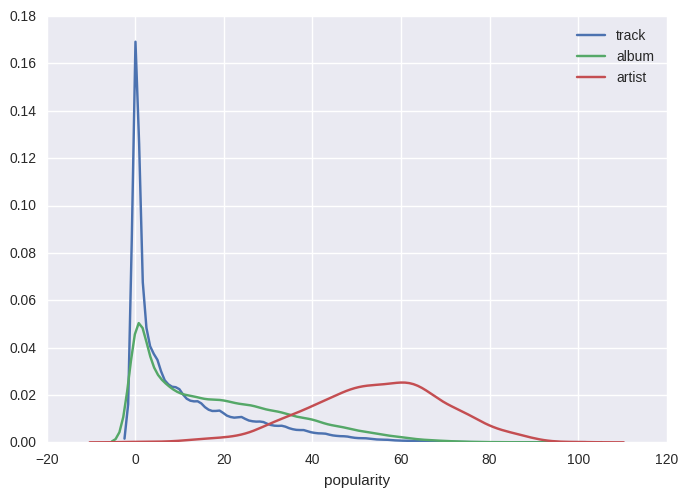

In [13]:
sns.distplot(tracks["popularity"], hist=False, label="track")
sns.distplot(albums["popularity"], hist=False, label="album")
sns.distplot(artists["popularity"], hist=False, label="artist")
plt.show()

Interestingly enough, it turns out that the majority of tracks have a popularity close to zero and very little have a popularity higher than even 50. The same cannot be said for artists however, which look to be somewhat normally distributed around 50.

According to Spotify, the algorithm that determines a track's popularity focuses mainly on the number of plays and how recent the plays are. Knowing this, you would think that since newer songs get played more, making them more popular. This means that the average popularity of songs should increase each year. To test this, I grouped the tracks by year and created a violin plot of the popularities each year.

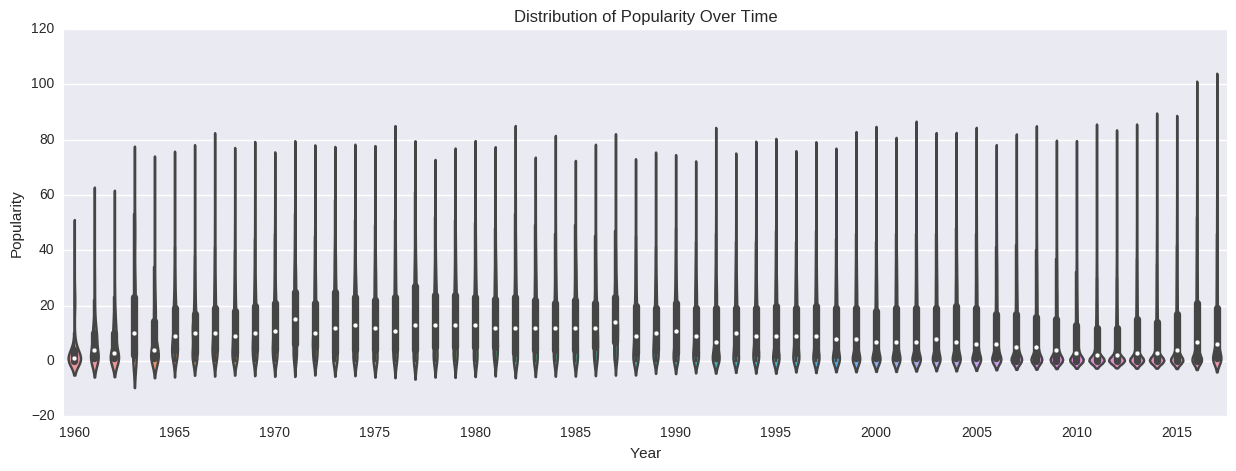

In [14]:
plt.figure(figsize=(15,5))
ax = sns.violinplot(x="year", y="popularity", data=tracks_features)
ax.set_xticks(np.arange(0, max(tracks_features.year)+1 - min(tracks_features.year), 5))
ax.set_xticklabels(np.arange(min(tracks_features.year), max(tracks_features.year)+1, 5))
plt.title('Distribution of Popularity Over Time')
plt.xlabel('Year')
plt.ylabel('Popularity')
plt.show()

Not what I was expecting. The average popularity is consistently close to zero, even in the recent years. This is most likely because the data is so heavily skewed. To see if this was true, I created the same chart but with only the top 10000 songs each year.

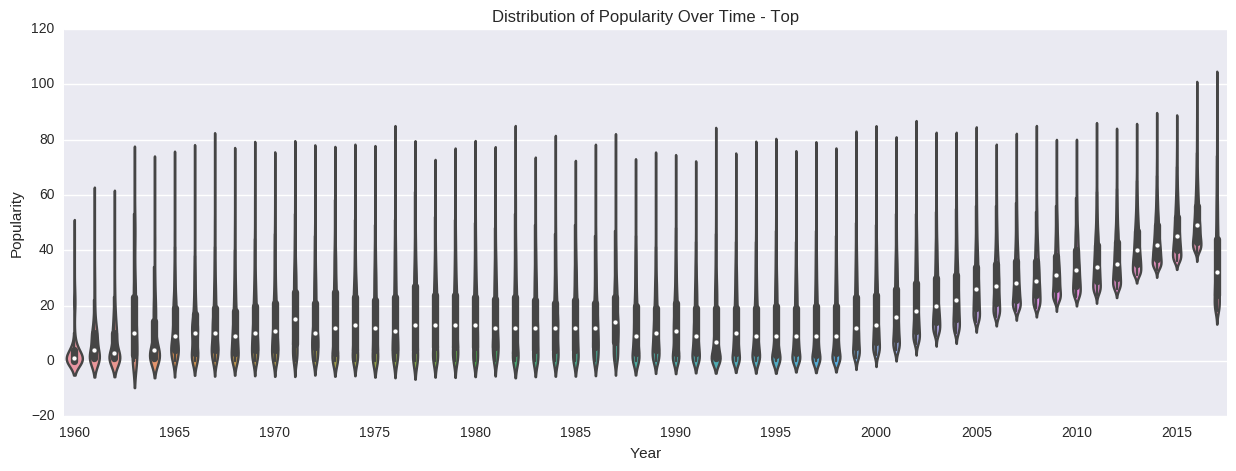

In [15]:
top = tracks_features.groupby(tracks_features["year"])[["year", "popularity"]].apply(
    lambda a: a.nlargest(10000, "popularity"))

plt.figure(figsize=(15,5))
ax = sns.violinplot(x="year", y="popularity", data=top)
ax.set_xticks(np.arange(0, max(top.year)+1 - min(top.year), 5))
ax.set_xticklabels(np.arange(min(top.year), max(top.year)+1, 5))
plt.title('Distribution of Popularity Over Time - Top')
plt.xlabel('Year')
plt.ylabel('Popularity')
plt.show()

This change in distribution is more like what I would expect to see. The popularities stay distributed close to zero until about the year 2000. At this point, the number the popularities are centered around steadily increases. This is true until the current year, 2017, at which point the averge popularity significantly decreases. This most likely occurs because songs from the current year may not have had enough time to reach their peak popularity, whereas songs from past years have.

With this evidence of a correlation between release date and popularity, let's take a look a the actual correlation along with the correlation between all of the other variables. This can be achieved by plotting the result of running ```corr()``` on the Dataframe we are working with.

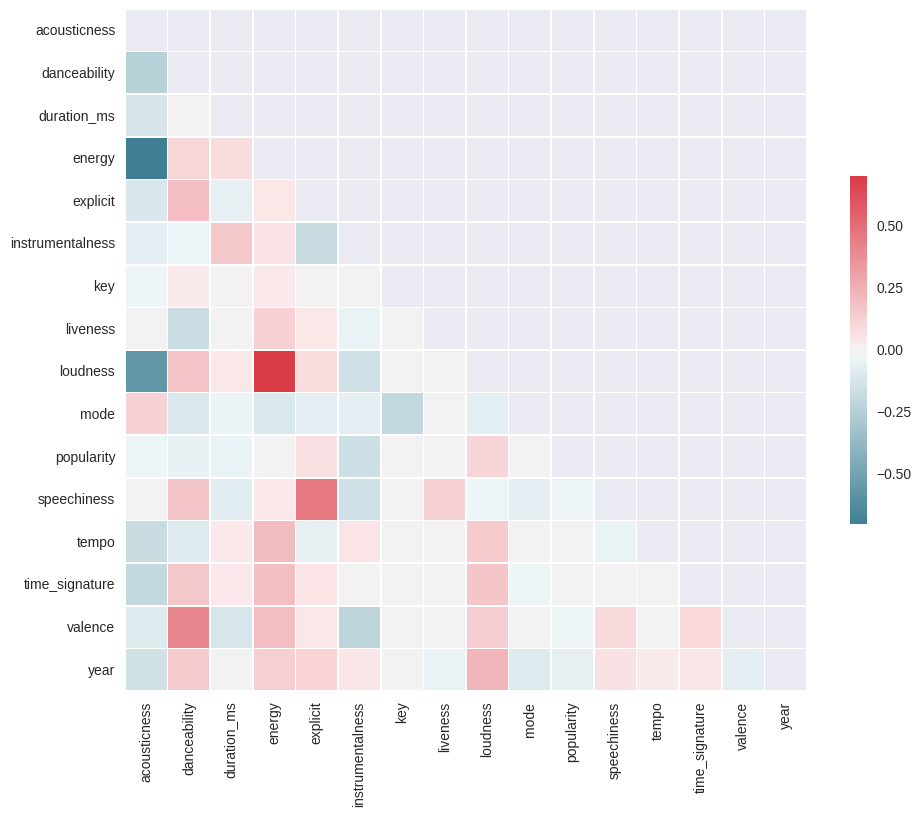

In [16]:
# Get the correclation values
corr= tracks_features.corr()

# Create a mask so only the lower trianlge is displayed
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11,9))

# Create the color scale
cmap = sns.diverging_palette(220,10, as_cmap=True)

# Plot the correlations
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, square=True, linewidths=.5, cbar_kws={"shrink":.5}, ax=ax)
plt.show()

Some that are worth noting:

1. Energy and Loudness are very highly related, positively
2. Acousticness is negatively related with Loudness and Energy
3. Explicit songs are positively correlated to Speechiness
4. Valence and Danceability are positively correlated

These things are fairly intuitive when thinking about music, however it is impressive that Spotify's algorithm for determining these values can recreate this intuition.

It is slighltly worrisome to see that popularity is not correlated to any one variable in particular considering that we are attempting to predict this value, but we will see what happens. It is however, slightly related to instrumentalness and loudness which, again, agrees with intuition. 

Since styles of music and what is considered popular chanes over time, there is potentially interaction between release date and all other variables, including popularity. Instead of adding interaction variables to account for this (a transormation that would make this problem exponentially more complicated), I think it would be interesting to instead look at only songs released recently. This should, theoretically, remove the time-series element of the data, given that the range is small enough. It will also make observations more applicable to contemporary music.

For this subset, I have choosen all songs released in the years 2015 and 2016. I did not include 2017 because of the observation made earlier, songs released in 2017 have not reached their top popularity yet.

The album type should also be changed to a number representation so it can be used in the model. To do this, we will map the album type to an integer representing the category. 

In [17]:
# Update columns
tracks_features = tracks_features.drop("release_date", axis=1)
tracks_features["album_type"] = tracks_features["album_type"].cat.codes

# Create smaller dataset
tracks_features_recent = tracks_features[(tracks_features.year >= 2015) & (tracks_features.year < 2017)]

After making these observations, we are ready to try to make predictions of song popularity.

## Predicting Popularity

To predict the popularity of a track , we will use two of SciKit Learn's algorithms: Linear Regression and Stochastic Gradient Descent (SGD). I decided to do linear regression because of it's simplicity and SGD under the recommendation of this chart here:

* http://scikit-learn.org/stable/tutorial/machine_learning_map/

Details of the particular functions are described here:

* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor

The firt step in machine learning is to split the datasets into both a training and testing set by randomly selecting a portion of the rows to be set aside. I will be using a training size of 70% and a testing of 30%

In [18]:
X = tracks_features_recent.drop("popularity", axis=1)
y = tracks_features_recent["popularity"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3)

Scikit learn makes creating these models extremely simple. To do so, the relative constructors need to be called and then be fit on the training data.

In [19]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

sgd = linear_model.SGDRegressor()
sgd.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

After the models have been fit, the ```predict()``` function can be called on the test data in order to check the effectiveness of the model. The r-sqaured values are also printed out here to check how well the algorithms modeled the data.

The predictions are normalized here by subtracting the minimum prediction and dividing by the range of predicitons and then multiplying by 100 to ensure the predictions are on a scale of 0 to 100, the scale the actual popularities are on.  

In [20]:
preds_lr = lr.predict(X_test)
# Normalize
preds_lr = (preds_lr - preds_lr.min())/(preds_lr.max() - preds_lr.min())*100

print("Linear Regression Score:", lr.score(X_test, y_test))

preds_sgd = sgd.predict(X_test)
# Normalize
preds_sgd = (preds_sgd - preds_sgd.min())/(preds_sgd.max() - preds_sgd.min())*100

print("SGD Score:", sgd.score(X_test, y_test))

Linear Regression Score: 0.0699274313574
SGD Score: -6.44472676366e+35


These values are pretty low, but that is not too surprising to me considering not much of any correlation was found earlier. Let's plot the distribution of the predictions to see if they resemble the true values at all.

/home/chris/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


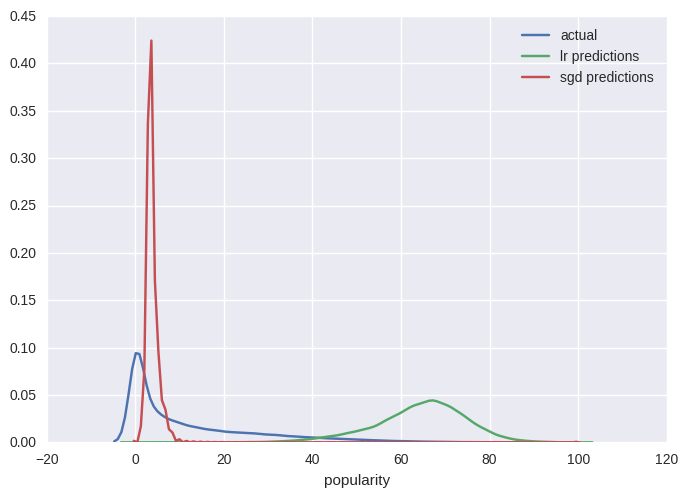

In [21]:
sns.distplot(y_test, hist=False, label="actual")
sns.distplot(preds_lr, hist=False, label="lr predictions")
sns.distplot(preds_sgd, hist=False, label="sgd predictions")
plt.show()

This is very interesting. Neither of the algorithms produced predictions that are distributed even close to the actual distribution. The SGD model predicted the majority of the tracks to have a popularity close to 100. This does not make much sense to me considering basically the opposite is true, the majority have popularities closer to 0. Lets no plot the distributions of the residuals and see what we can find there.

/home/chris/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


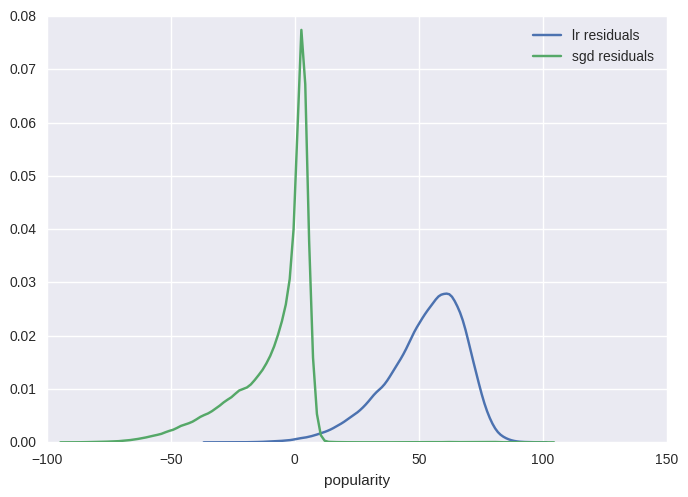

In [22]:
sns.distplot((preds_lr - y_test), hist=False, label="lr residuals")
sns.distplot((preds_sgd - y_test), hist=False, label="sgd residuals")
plt.show()

These distributions are similar to the distributions of the values themselves which makes sense.

## Results

Sadly, it looks as though the popularity of a song cannot be predicted by the features of that song. Although these findings are rather disappointing, they are not surprising and the process to find that out was pretty fun! Song popularity is an organic thing and there is no formula for a perfect song.